In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from statsmodels.tsa.arima.model import ARIMA

# Load daily drug sales data

In [2]:
# Load dataset
dfd = pd.read_csv('../Data/salesdaily.csv')

# Normalize
dfd[dfd.columns[1:9]] = dfd[dfd.columns[1:9]]/np.linalg.norm(dfd[dfd.columns[1:9]])

# Create new date columns
dfd['datum']= pd.to_datetime(dfd['datum'])
dfd["day_number"] = pd.DatetimeIndex(dfd['datum']).day
dfd['Month'] = pd.DatetimeIndex(dfd['datum']).month
dfd['Year'] = pd.DatetimeIndex(dfd['datum']).year
drug_list = dfd.columns[1:9]
dfd.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name,day_number
0,2014-01-02,0.000000,0.002131,0.001974,0.018812,0.004064,0.000000,0.000000,0.001161,2014,1,248,Thursday,2
1,2014-01-03,0.004645,0.002322,0.002555,0.029379,0.009290,0.000000,0.011612,0.002322,2014,1,276,Friday,3
2,2014-01-04,0.001161,0.000581,0.003774,0.035911,0.005806,0.000000,0.005225,0.000581,2014,1,276,Saturday,4
3,2014-01-05,0.002322,0.001742,0.004064,0.023863,0.004645,0.000000,0.001742,0.000000,2014,1,276,Sunday,5
4,2014-01-06,0.002903,0.000581,0.002613,0.012599,0.009290,0.001161,0.003484,0.001161,2014,1,276,Monday,6


In [3]:
# Check for empty strings 
empty = np.array([(dfd[col].astype(str).unique() == '').any() for col in dfd.columns.tolist()])
print("Any empty strings: " + str((empty == True).any()))

# Check for any missing data
print('\nAny missing data (by column):')
display(dfd.isnull().any())

Any empty strings: False

Any missing data (by column):


datum           False
M01AB           False
M01AE           False
N02BA           False
N02BE           False
N05B            False
N05C            False
R03             False
R06             False
Year            False
Month           False
Hour            False
Weekday Name    False
day_number      False
dtype: bool

In [4]:
# Get total drug sales
total_drug = np.sum(dfd.set_index('datum')[drug_list], axis=1)

# creating training and test datasets
train, test = train_test_split(total_drug, test_size=.1, shuffle=False)
display(train)
display(test)

datum
2014-01-02    0.028142
2014-01-03    0.062125
2014-01-04    0.053038
2014-01-05    0.038378
2014-01-06    0.033791
                ...   
2019-03-07    0.029992
2019-03-08    0.028374
2019-03-09    0.046570
2019-03-10    0.047765
2019-03-11    0.043098
Length: 1895, dtype: float64

datum
2019-03-12    0.036028
2019-03-13    0.033100
2019-03-14    0.059843
2019-03-15    0.046547
2019-03-16    0.037262
                ...   
2019-10-04    0.030611
2019-10-05    0.027625
2019-10-06    0.039185
2019-10-07    0.047985
2019-10-08    0.041142
Length: 211, dtype: float64

# Look at total drug sale data

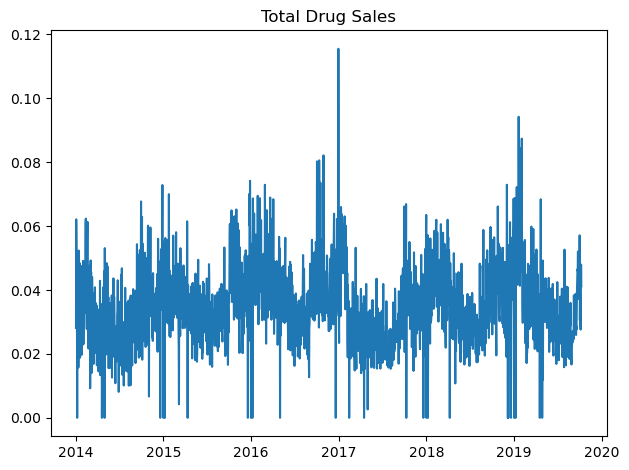

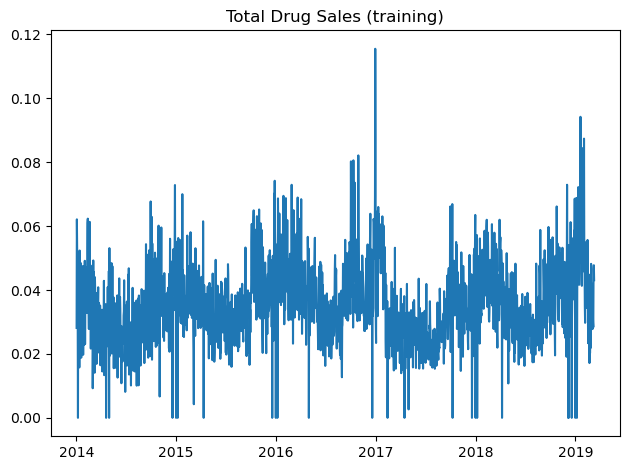

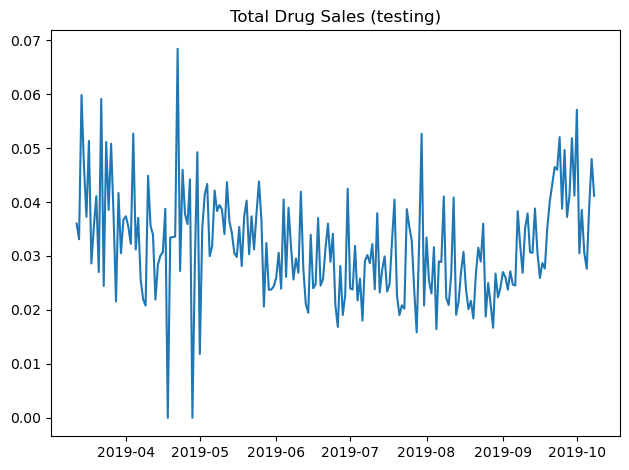

In [5]:
# Plot total drug sales over time for each drug
plt.plot(total_drug)
plt.title('Total Drug Sales')
plt.tight_layout()
plt.show()
plt.plot(train)
plt.title('Total Drug Sales (training)')
plt.tight_layout()
plt.show()
plt.plot(test)
plt.title('Total Drug Sales (testing)')
plt.tight_layout()
plt.show()

# Decompose training data

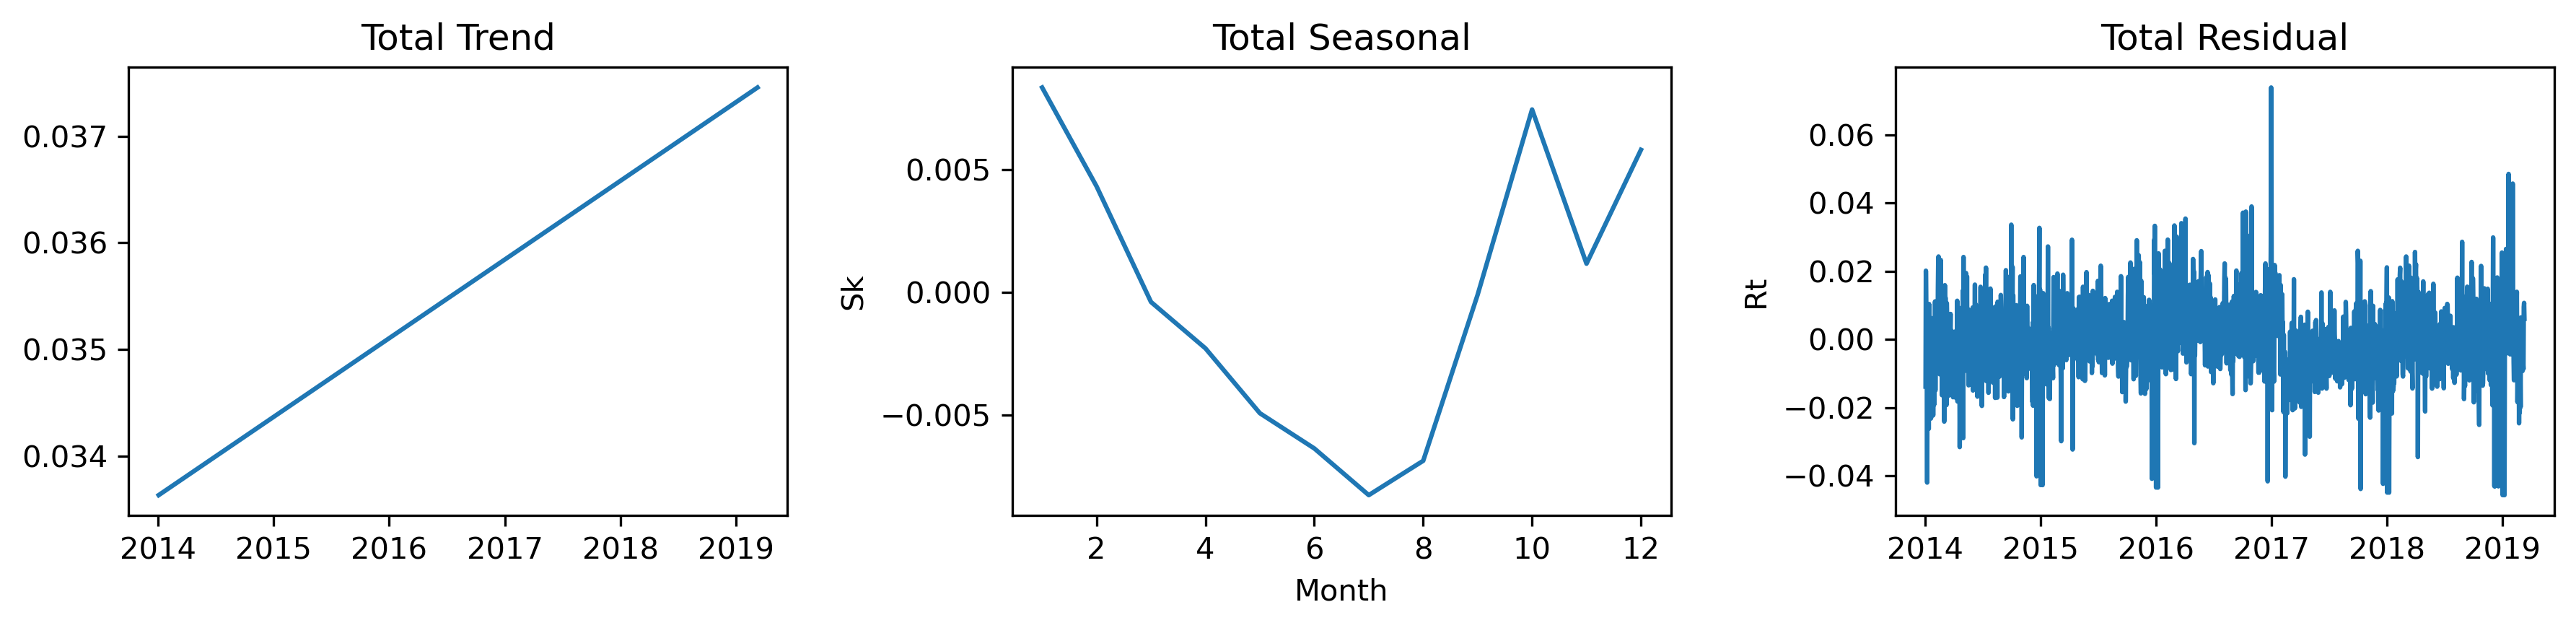

In [6]:
plt.figure(figsize=(12,3), dpi=300)
# Get drug's time series
ts = train

# Fit polynomial to data
tlen = 365
coefficients = np.polyfit(np.arange(len(ts)), list(ts),1)
poly = np.poly1d(coefficients)
trends = poly
dates = ts.index.values

# Get trend
Tt = poly(np.arange(len(ts)))
plt.subplot(131)
plt.plot(dates, Tt)
plt.title('Total Trend')

# Detrend the series
yt = ts - Tt

# Find Sk
Sk = yt.groupby(yt.index.month).mean()
seasonal = Sk

# Plot sk
plt.subplot(132)
Sk.plot()
plt.xlabel('Month')
plt.ylabel('Sk')
plt.title('Total Seasonal')

# Compute residuals
new = yt.reset_index()
new['Rt'] = new.apply(lambda row: row[0] - Sk[row['datum'].month], axis=1)
Rt = new.set_index('datum')['Rt']
residuals = Rt

# Plot
plt.subplot(133)
plt.plot(Rt)
plt.ylabel('Rt')
plt.title('Total Residual')
plt.tight_layout()
plt.show()

# Look at the distribution of the residuals

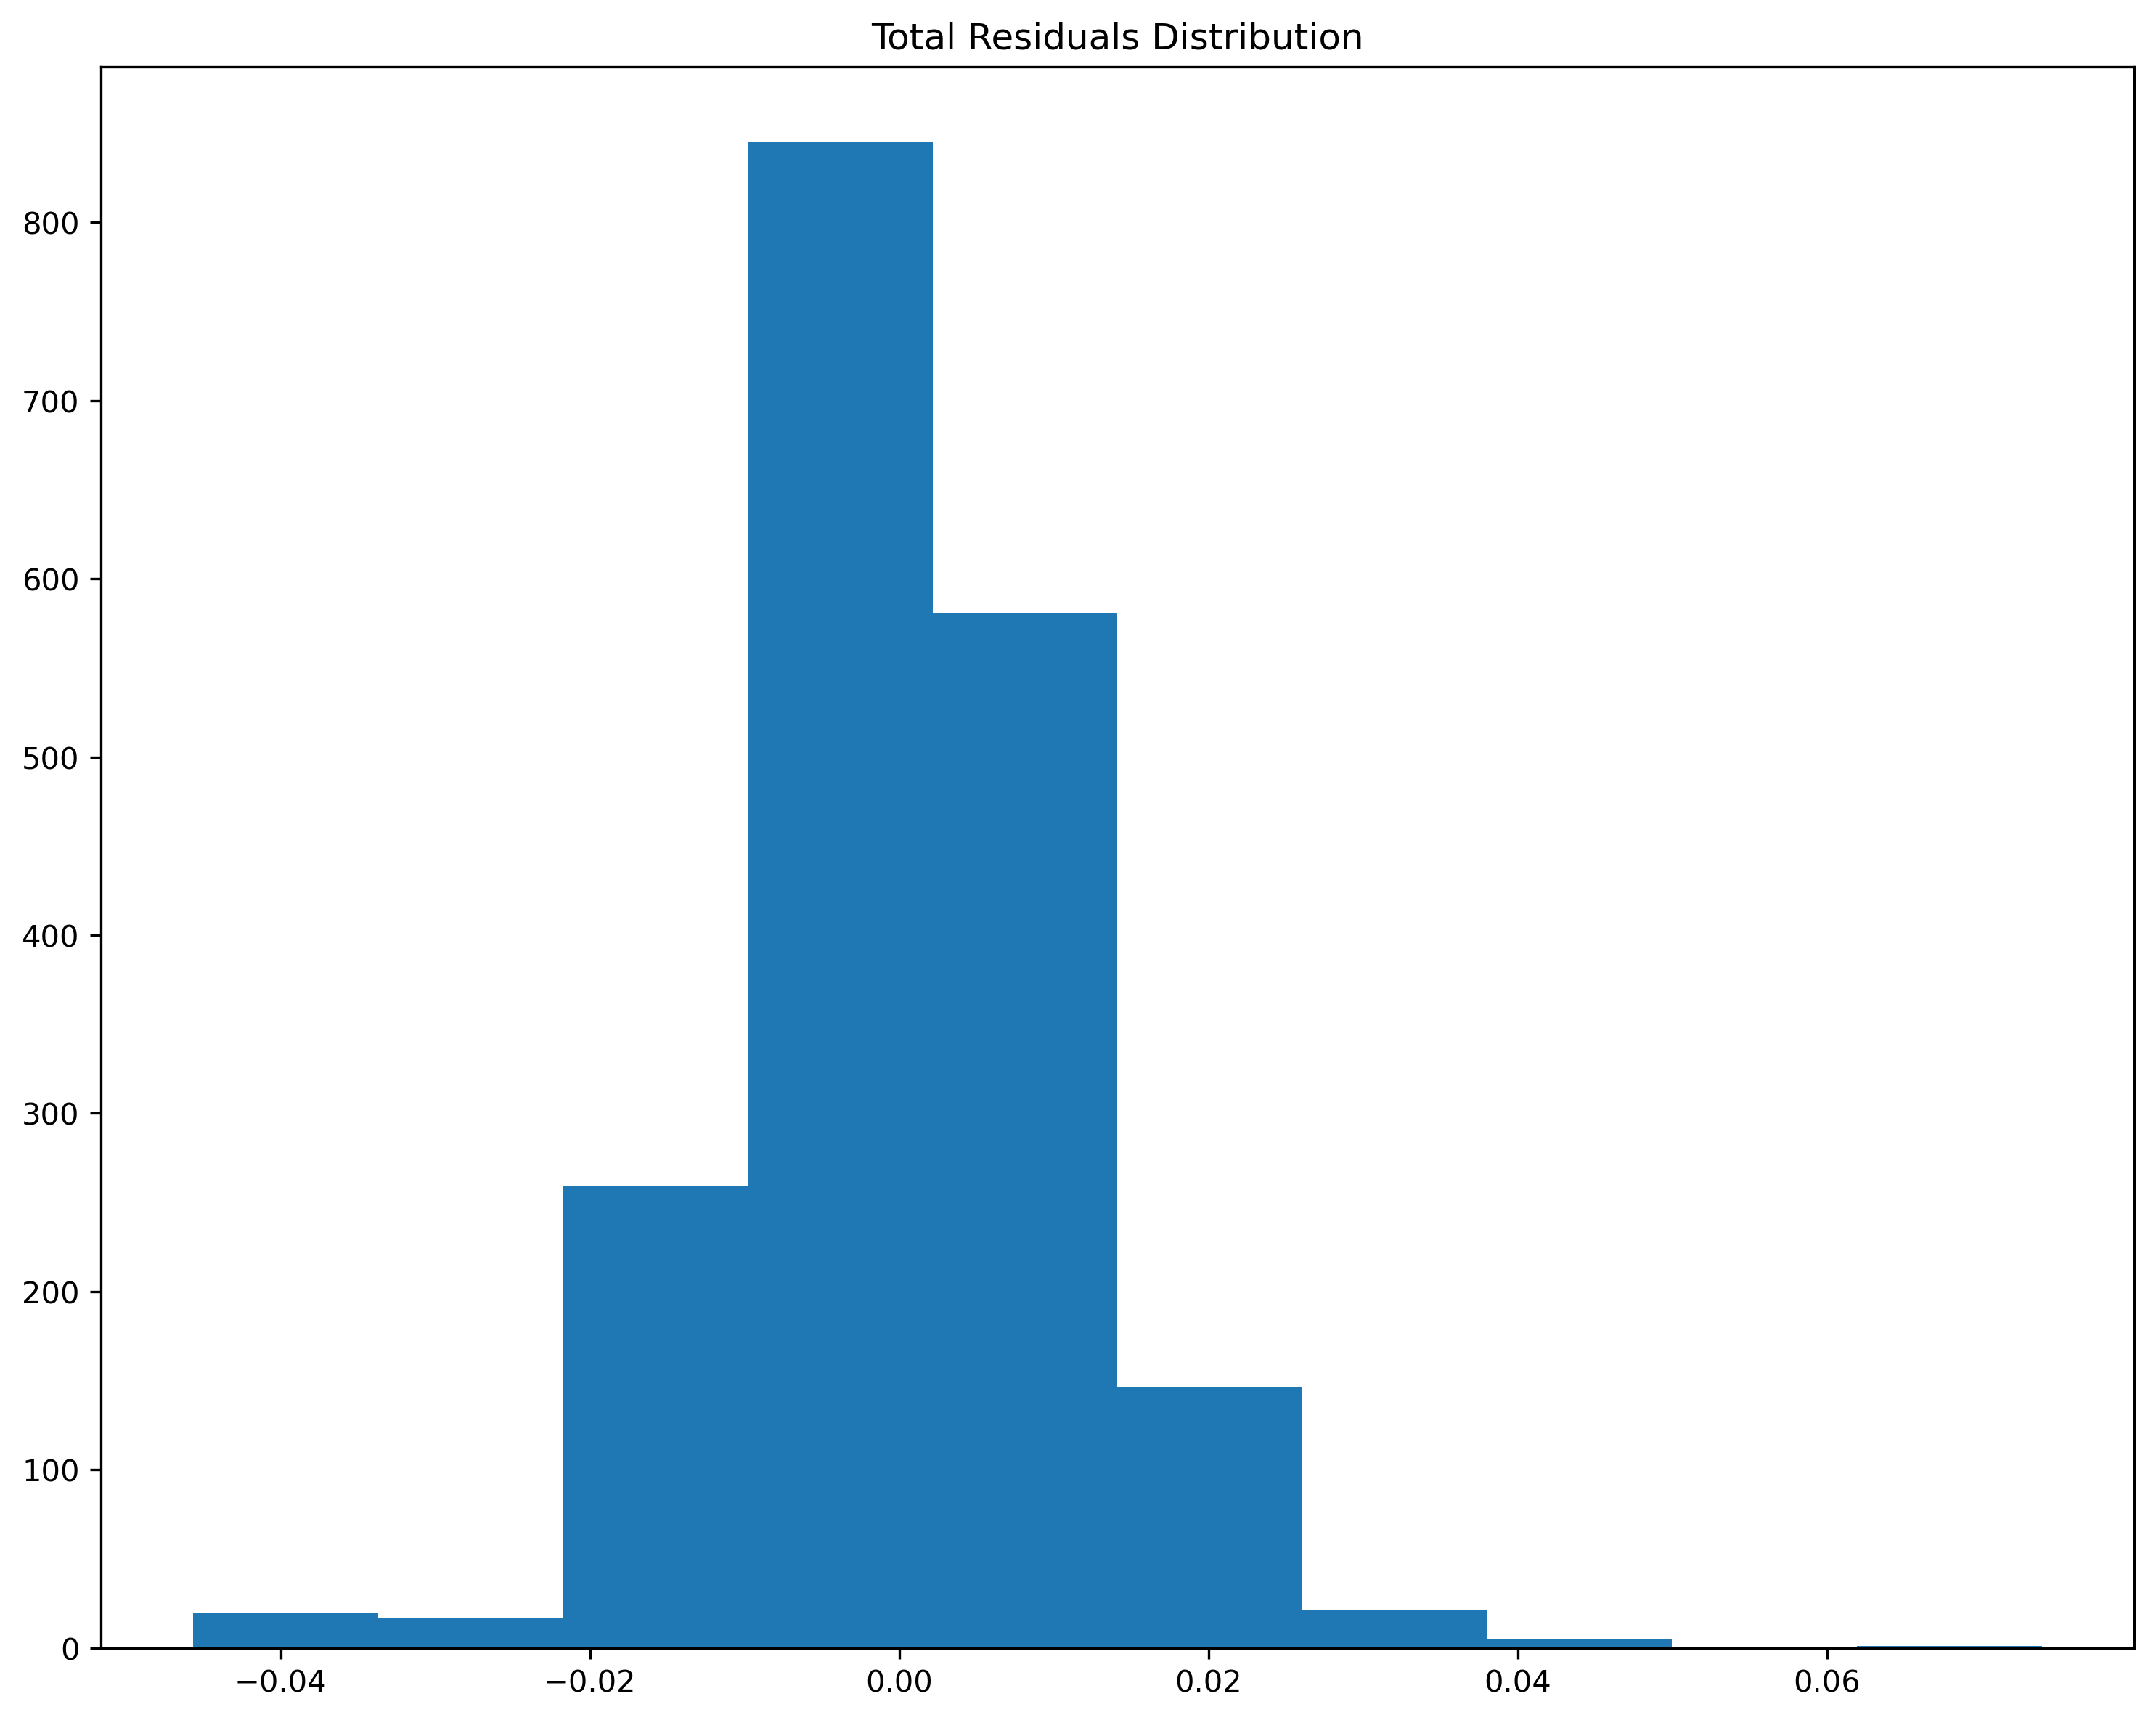

In [7]:
# Get the weekly residuals
plt.figure(figsize=(10,8), dpi=300)
plt.hist(residuals)
plt.title('Total Residuals Distribution') 
plt.tight_layout()
plt.show()

In [8]:
def model_identification(ts,p_max=4,q_max=4, ours=False):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    
    # Load time series
    time_series = ts
    n = len(time_series)
    best_aic = np.inf

    # Perform the grid search
    for p in range(1, p_max+1):
        for q in range(1, q_max+1):
            # Create ARIMA model
            model = ARIMA(time_series,order=(p,0,q),trend='c', freq='D').fit(method='innovations_mle')

            # Compute curr aicc
            curr_aic = model.aic

            if curr_aic < best_aic:
                # Update the best model and AIC
                best_model, best_aic = model, curr_aic
                best_p, best_q = p, q
    
    return best_p, best_q

In [9]:
def arma_forecast(ts, best_p, best_q, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # Load time series
    data = ts

    # Get prediction
    best_model = ARIMA(ts,order=(best_p,0,best_q),trend='c', freq='D').fit(method='innovations_mle')
    prediction = best_model.predict(start=0, end=len(ts)+n)
    forecast = best_model.get_forecast(n)
    conf_int = forecast.conf_int(alpha=0.05)

    # Plot
    dates = pd.date_range(data.index.values[-1], periods=n)
    plt.figure(figsize=(12,10), dpi=300)
    plt.plot(data, label='Old Data')
    plt.plot(prediction, label='forecast')
    plt.plot(conf_int['lower Rt'], 'g', label='95% Confidence Interval')
    plt.plot(conf_int['upper Rt'], 'g')
    plt.xlabel('Year')
    plt.ylabel('Residuals')
    plt.title('ARMA')
    plt.legend()
    plt.show()
    return dates, prediction, conf_int

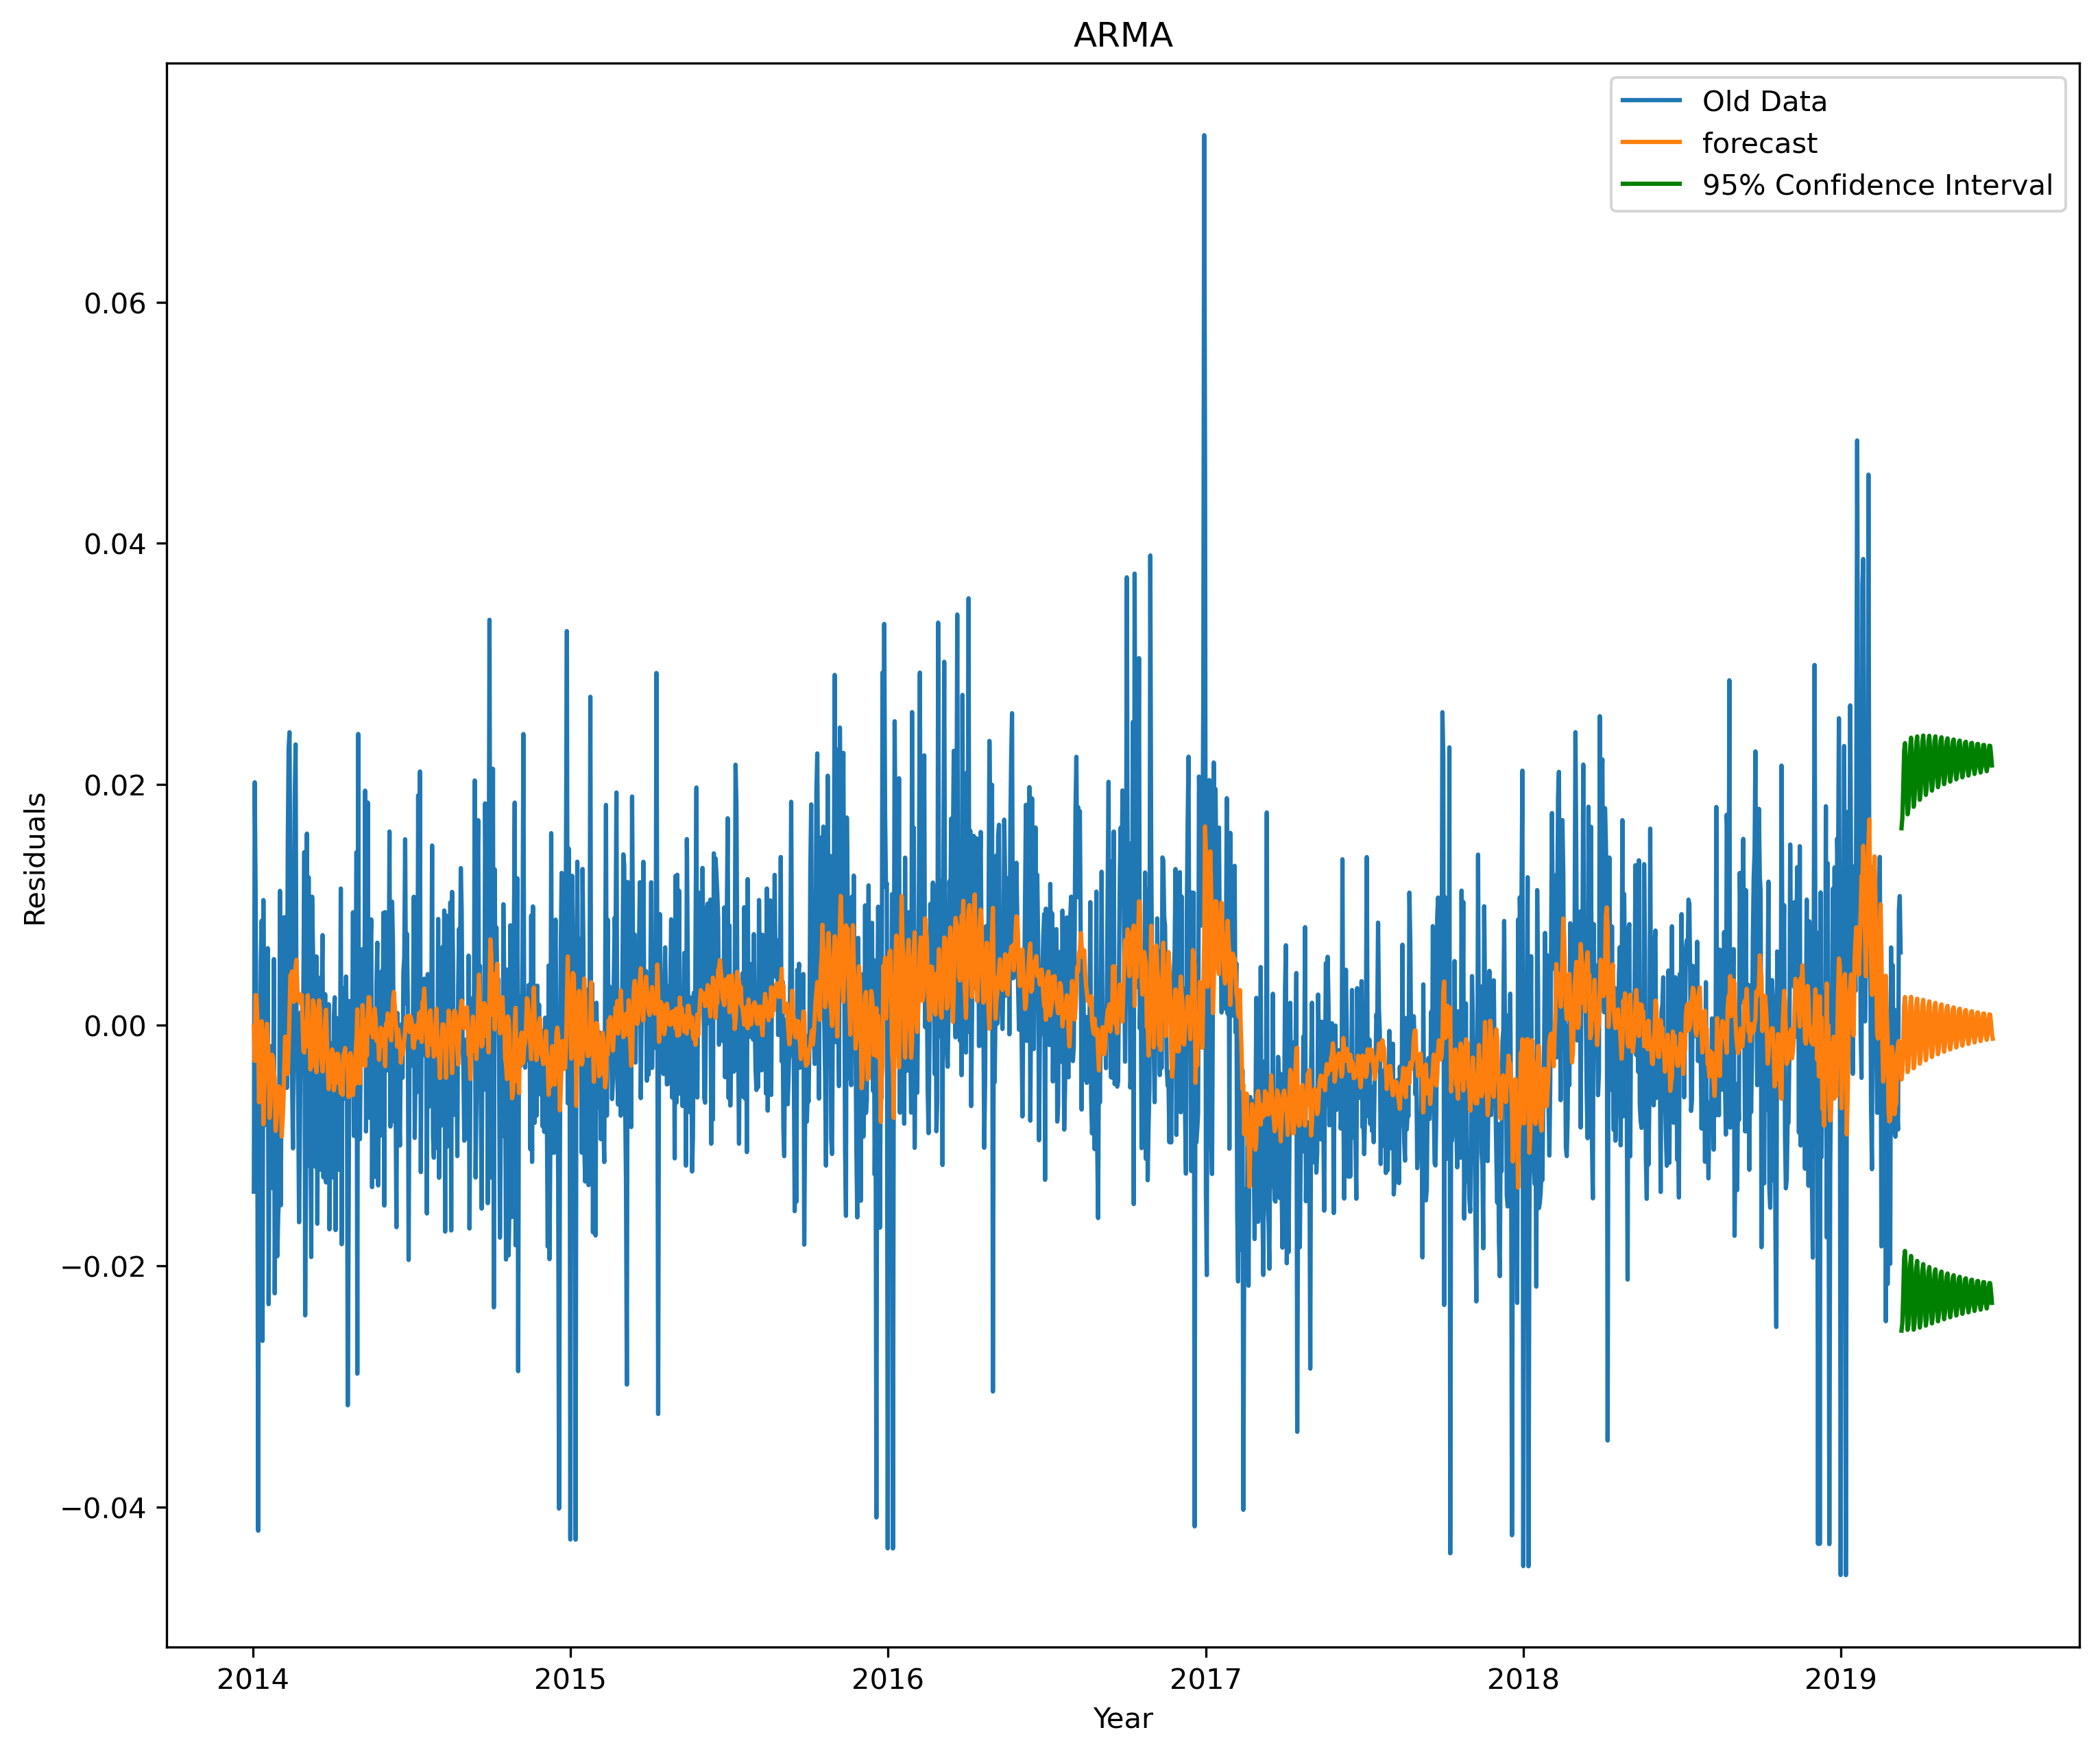

In [10]:
import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency D will be used.")

# Get ARMA prediction for specific drug
n = 105
best_p, best_q = model_identification(residuals, p_max=4, q_max=4, ours=False)
dates, prediction, conf_int = arma_forecast(residuals, best_p,best_q, n=n)


# Show prediction with trend and seasonal added in

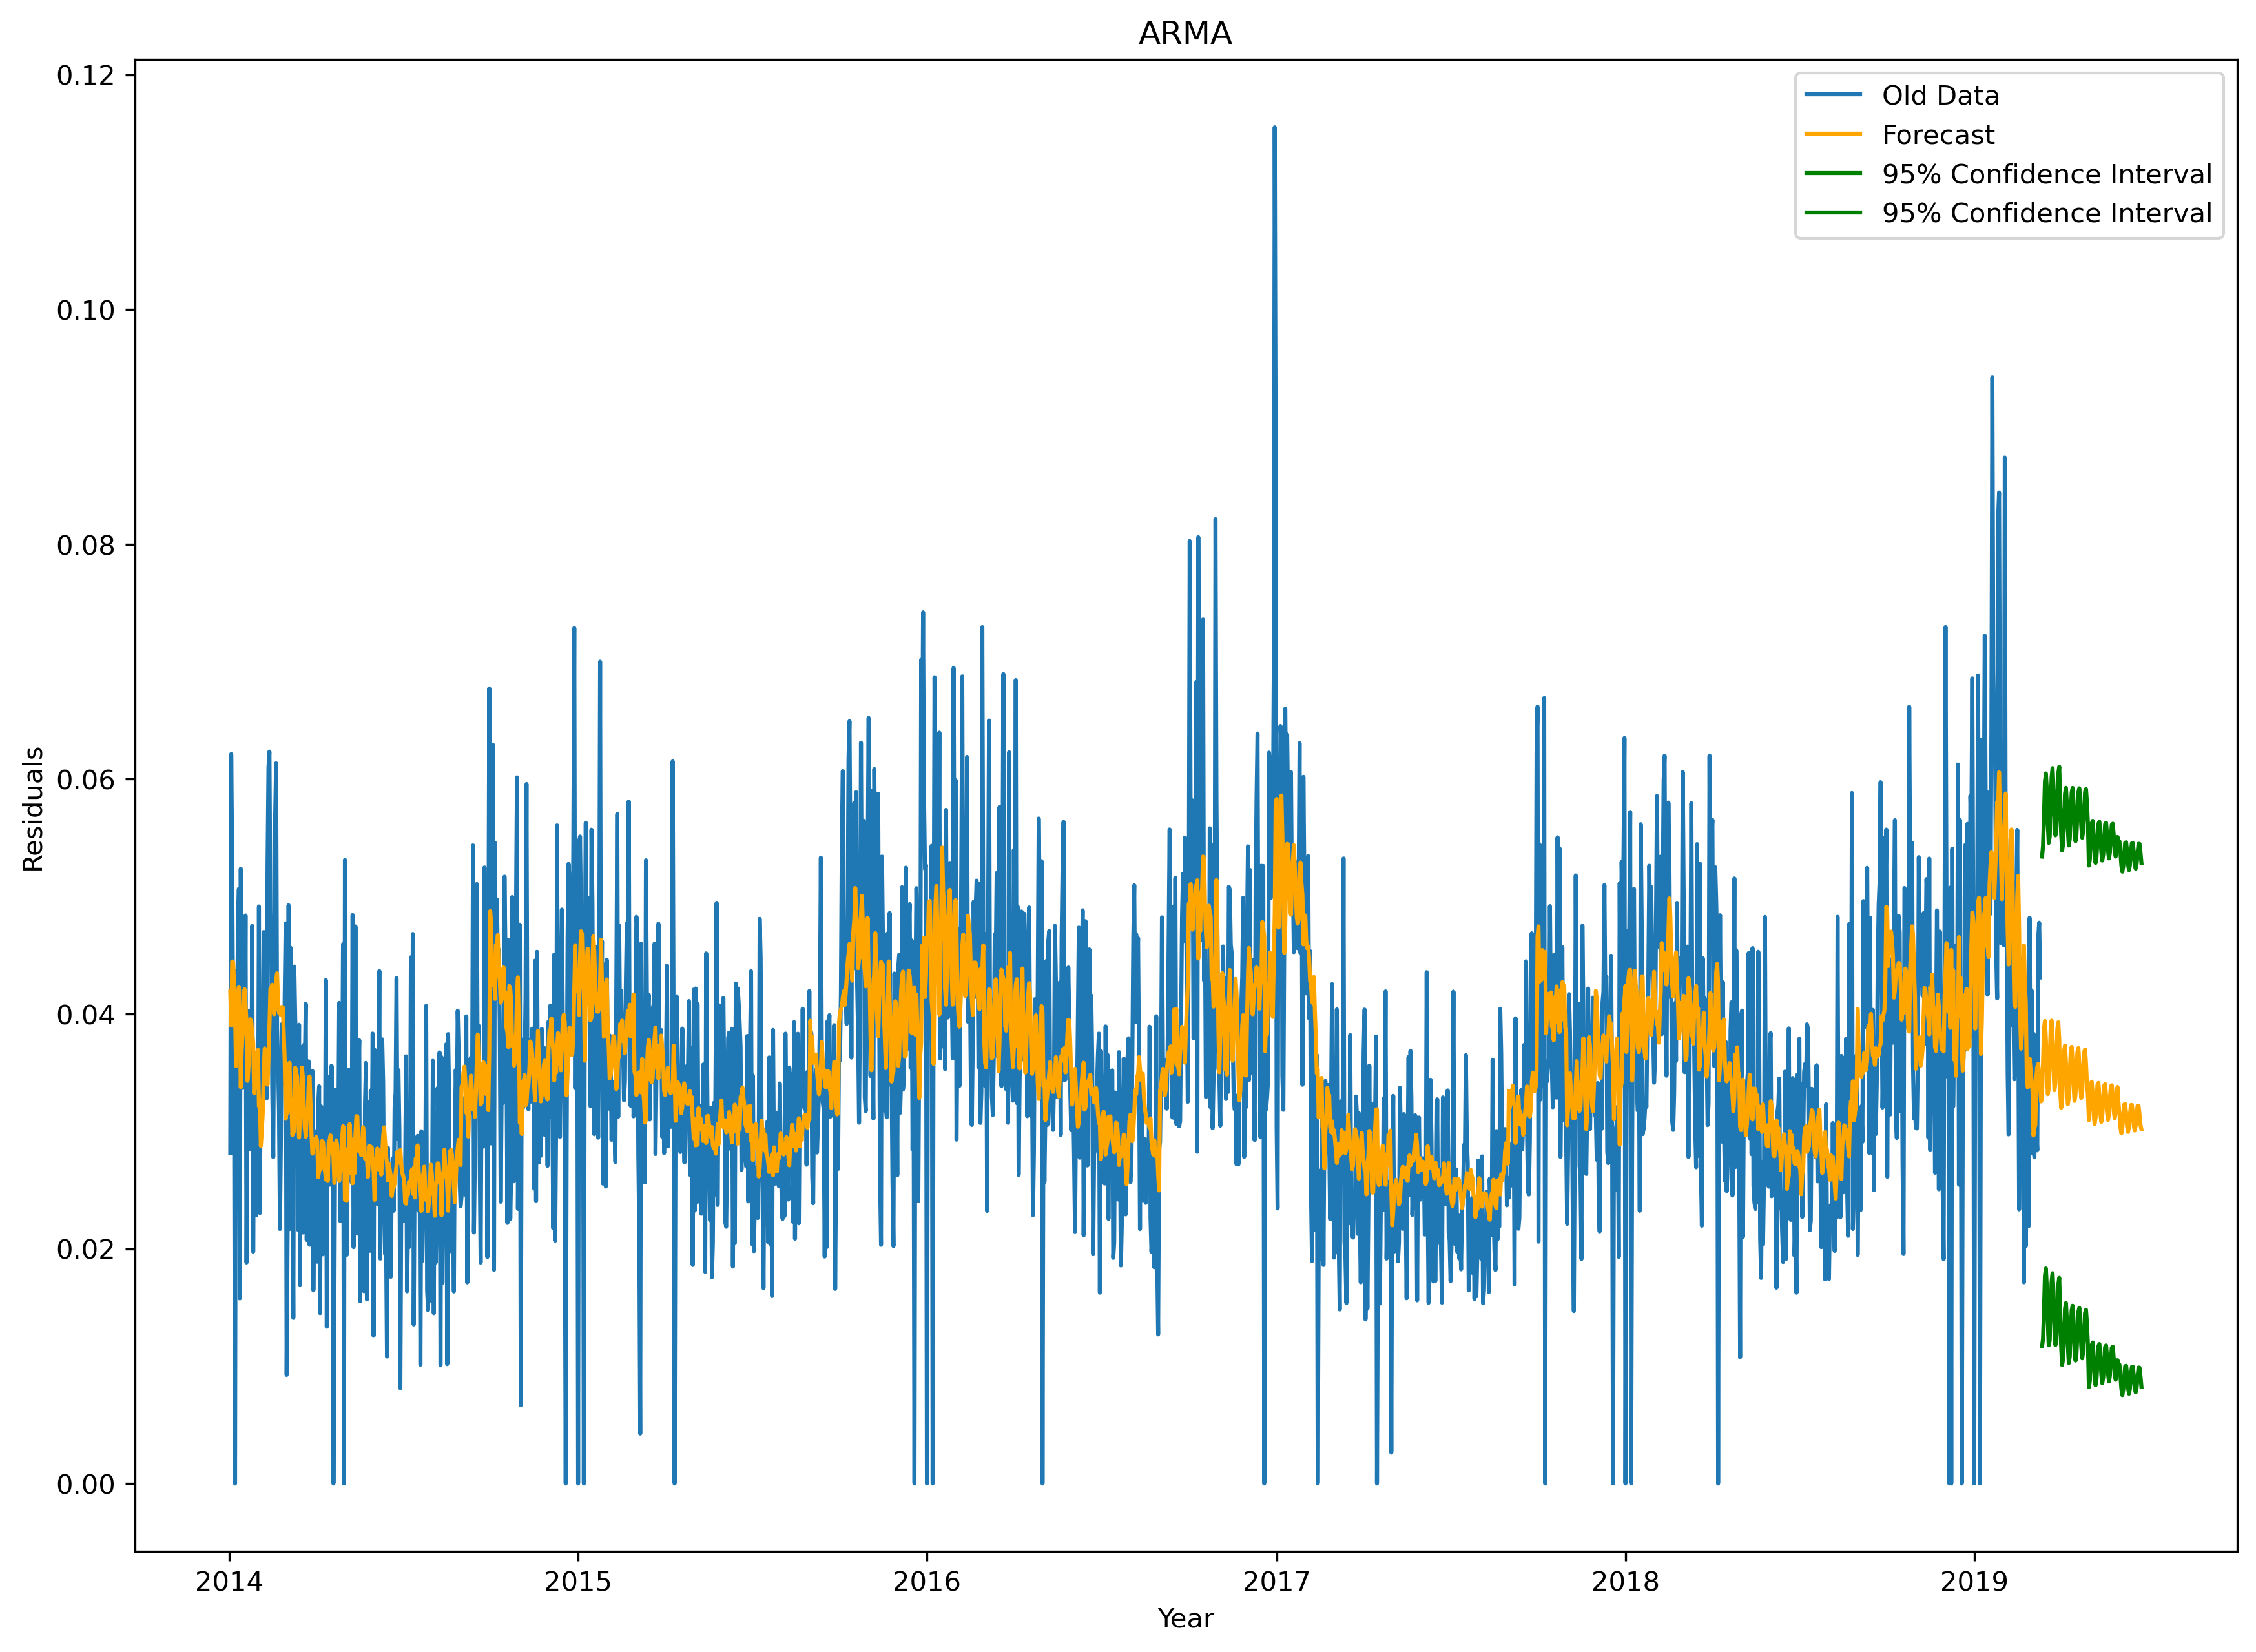

In [11]:
# Set initial variables
t_vals = np.arange(0,len(train) + n + 1)
current_trend = trends(t_vals)
dates = pd.date_range(list(dfd['datum'])[0], periods=len(train) + n + 1)
current_seasonal = seasonal[dates.month]
num_train = len(train)

# Plot
plt.figure(figsize=(14,10), dpi=300)
plt.plot(total_drug.index.values[:len(train)], total_drug[:len(train)], label='Old Data')
plt.plot(dates, current_trend + list(current_seasonal) + prediction, c='orange', label='Forecast')
plt.plot(dates[num_train+1:], current_trend[num_train+1:] + list(current_seasonal)[num_train+1:] + list(conf_int['lower Rt']), c='g', 
         label='95% Confidence Interval')
plt.plot(dates[num_train+1:], current_trend[num_train+1:] + list(current_seasonal)[num_train+1:] + list(conf_int['upper Rt']), c='g', 
         label='95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('ARMA')
plt.legend()
plt.show()

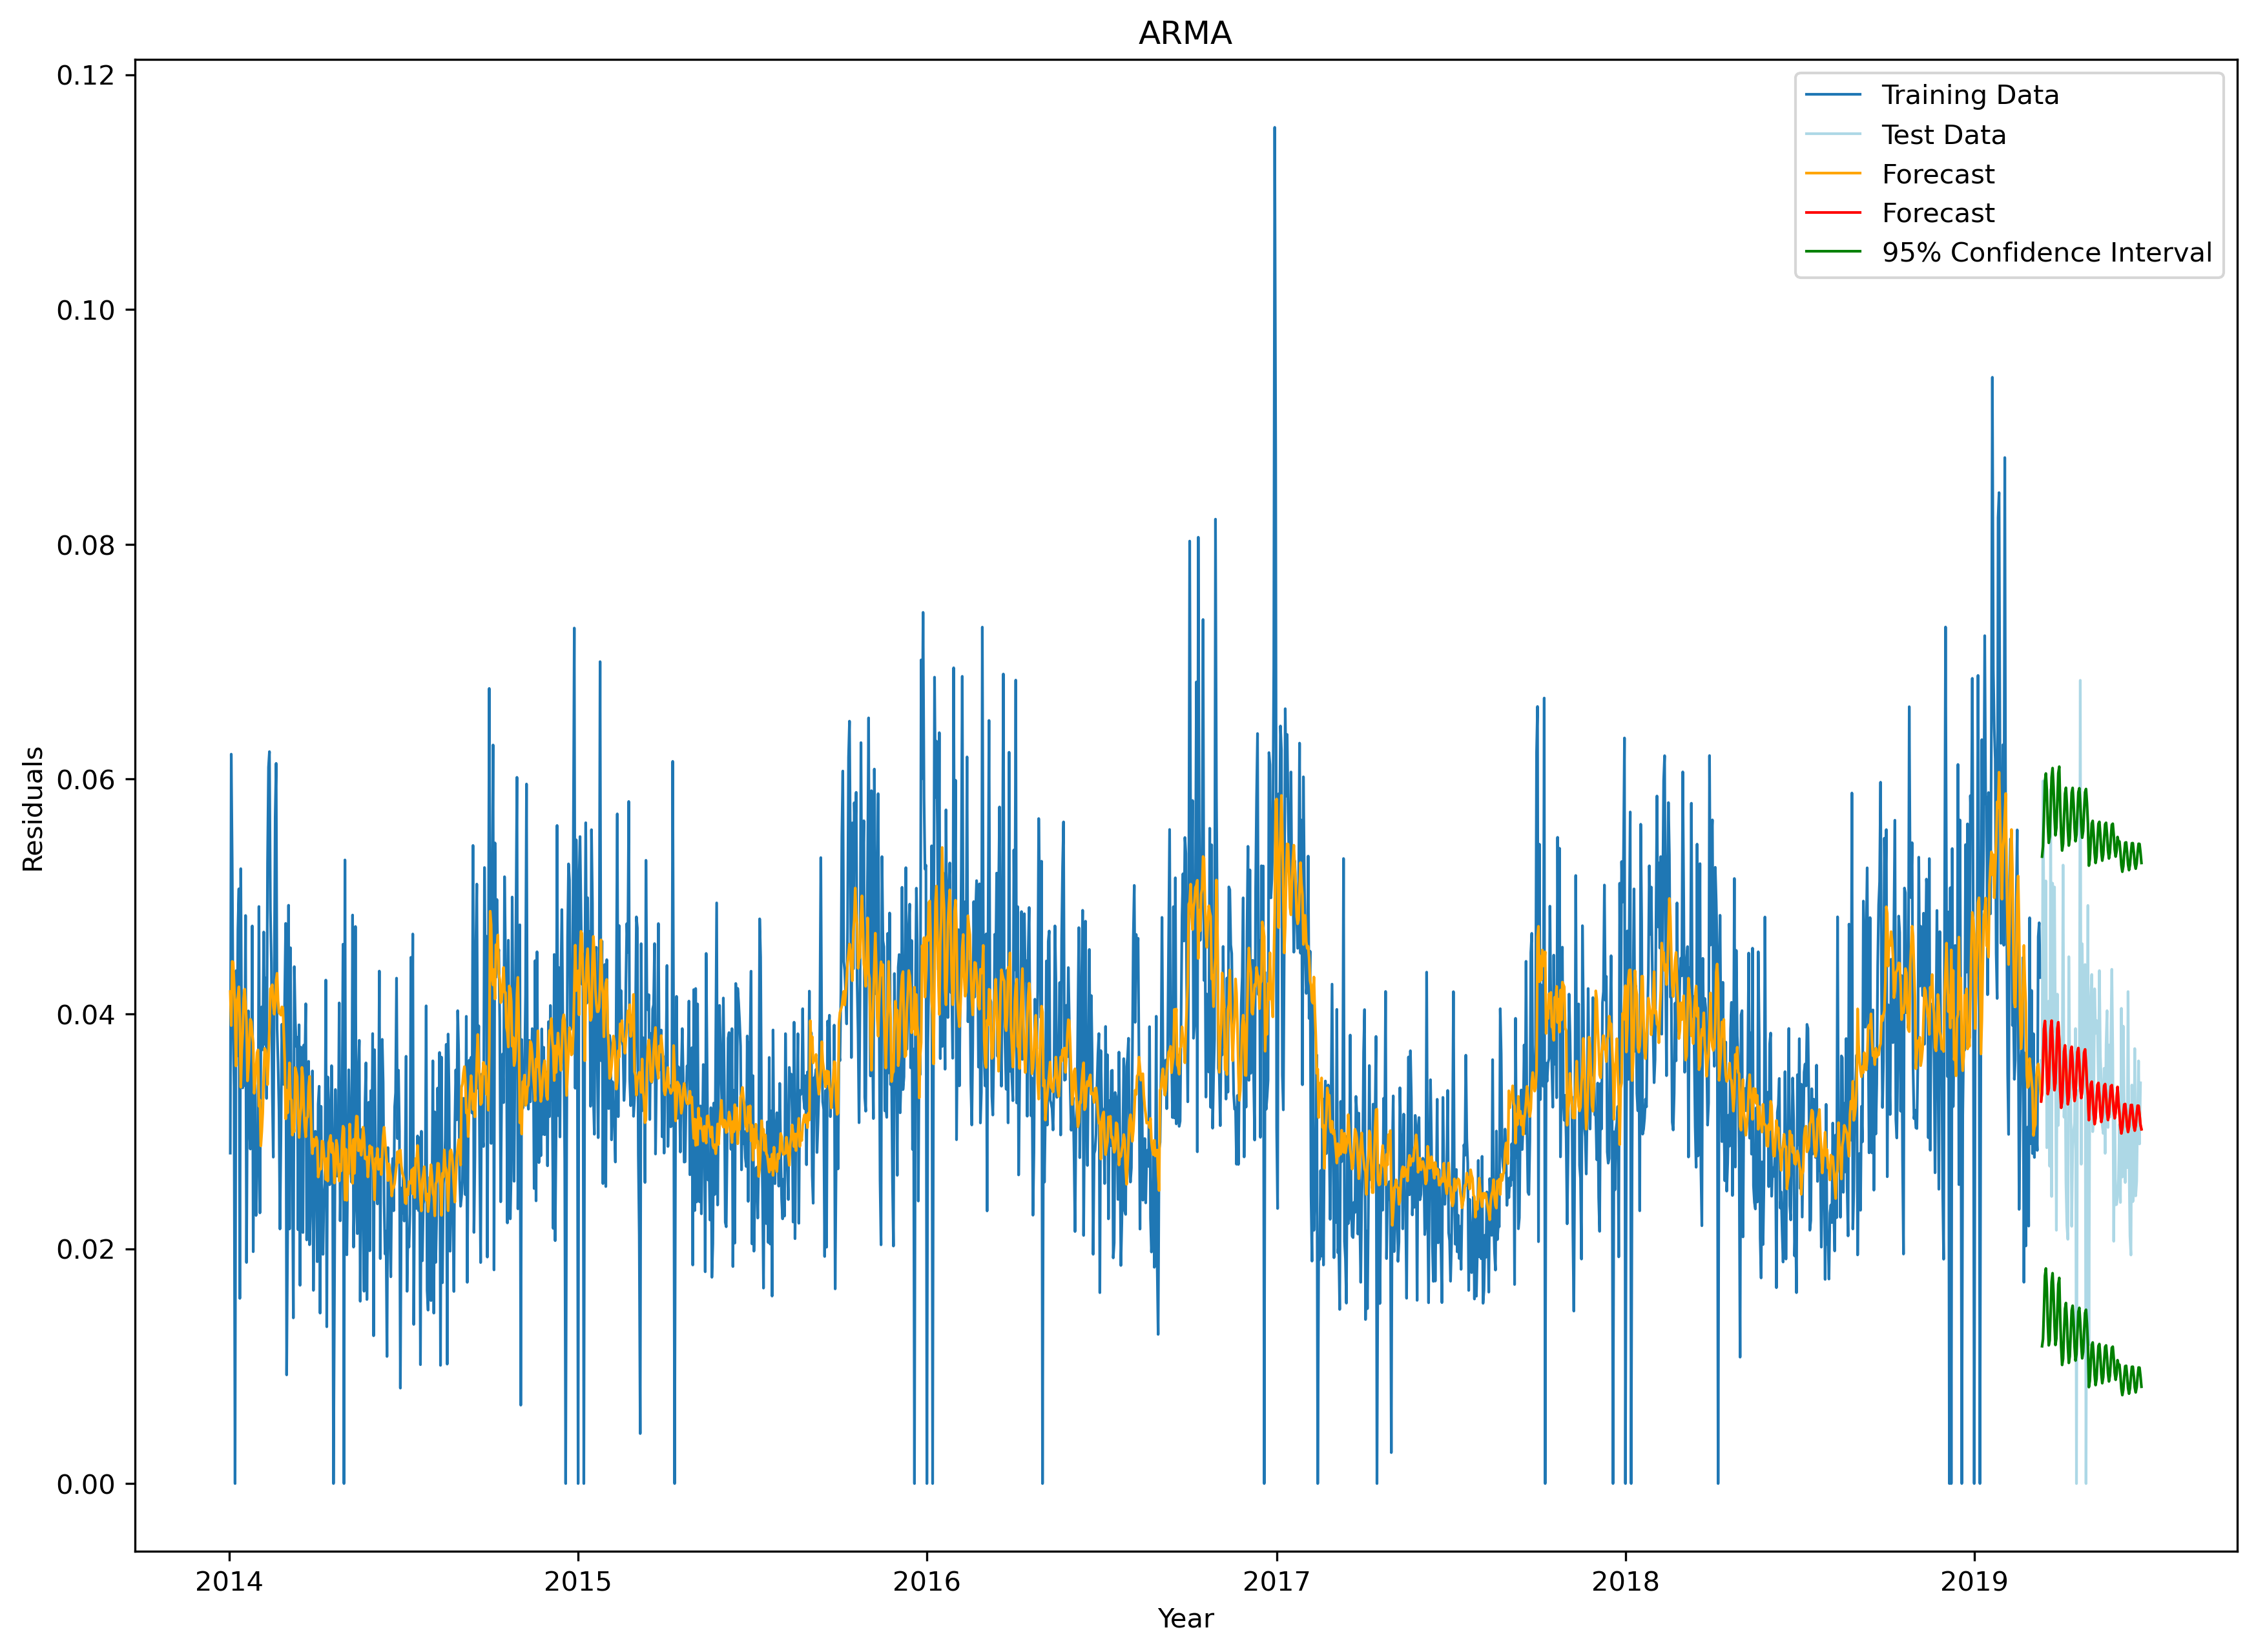

In [12]:
# Set initial variables
t_vals = np.arange(0,len(train) + n + 1)
current_trend = trends(t_vals)
dates = pd.date_range(list(dfd['datum'])[0], periods=len(train) + n + 1)
current_seasonal = seasonal[dates.month]
num_train = len(train)

# Plot
plt.figure(figsize=(14,10), dpi=300)
plt.plot(total_drug.index.values[:num_train], total_drug[:num_train], label='Training Data', linewidth=1)
plt.plot(total_drug.index.values[num_train:num_train+n], total_drug[num_train:num_train+n], 
         label='Test Data', color='lightblue', linewidth=1)
plt.plot(dates, current_trend + list(current_seasonal) + prediction, 
         c='orange', label='Forecast', linewidth=1)
plt.plot(dates[num_train:], (current_trend + list(current_seasonal) + prediction)[num_train:], 
         c='red', label='Forecast', linewidth=1)
plt.plot(dates[num_train+1:], current_trend[num_train+1:] + list(current_seasonal)[num_train+1:] + list(conf_int['lower Rt']), c='g', 
         label='95% Confidence Interval', linewidth=1)
plt.plot(dates[num_train+1:], current_trend[num_train+1:] + list(current_seasonal)[num_train+1:] + list(conf_int['upper Rt']), c='g'
         , linewidth=1)
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('ARMA')
plt.legend()
plt.show()